# Import Library

In [35]:
#基本數學/文件/系統 Package
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
#音頻處理
import librosa
import librosa.display 
SAMPLE_RATE = 44100
import joblib
import IPython.display as ipd
#資料處理
from sklearn.preprocessing import StandardScaler
#匯入SVM
from sklearn.svm import SVC
#繪圖
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
#匯入模型
import joblib
#統計計算
import scipy
from scipy.stats import skew

# Read Our Proposed Model

In [50]:
# 讀取模型
loaded_model = joblib.load('SVM_model')
loaded_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Data Exploration

In [65]:
# Import Test Audio
list_test = []
for j in os.listdir('./test/'):
        list_test.append('./test/'+j)
fname = list_test[0]

In [67]:
ipd.Audio(fname)

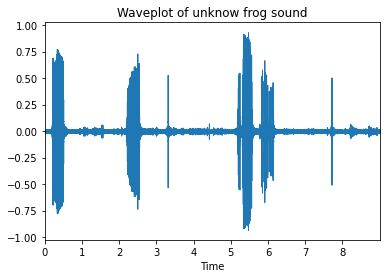

In [68]:
# 提取時域音頻資料
y, sr = librosa.load(fname, sr=SAMPLE_RATE)    
# plot a waveform
plt.figure()  
librosa.display.waveplot(y, sr)  
plt.title('Waveplot of unknow frog sound')  
plt.show() 

# Feature Extraction

In [54]:
SAMPLE_RATE = 44100
def get_mfcc(name, path):
    data, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), 
                               np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

C:\Users\user\Anaconda3\lib\site-packages\librosa\display.py:797: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\librosa\display.py:797: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


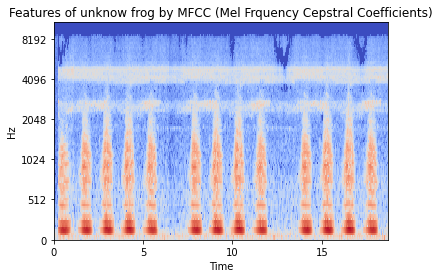

In [55]:
# 提取頻域音頻資料
# MFCC spectrogram feature  
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)  
# 轉成 log scale 已呈現頻譜資料  
logmelspec = librosa.power_to_db(melspec)  
# 繪圖  
plt.figure()  
librosa.display.specshow(logmelspec, sr=sr, x_axis='time', y_axis='mel')  
plt.title('Features of unknow frog by MFCC (Mel Frquency Cepstral Coefficients)')  
plt.show()

In [69]:
# 創建文件檔
from pandas.core.frame import DataFrame
test= pd.DataFrame({'fname':list_test})

In [70]:
# 特徵提取
test_data = test['fname'].progress_apply(get_mfcc, path='')
test_data = test_data.values
# 標準化
#scaler = StandardScaler()
#test_scaled = scaler.fit_transform(test_data)
test_scaled = test_data

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\user\Anaconda3\lib\site-packages\librosa\core\audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


# Prediction

In [71]:
labels = ['American_bull','Brauer_treefrog','Brown_treefrog','Butler',
 'Chinese_bull','Eiffinger','Emerald_treefrog','Farmland_treefrog',
 'Fujian','Green_pond','Gunther','Harpist','Heymon','Japanese_Buerger',
 'Latouchte','Long-legged','Malaysian_narrow_mouthed_toad','Mangrove',
 'Meintein_treefrog','Moltrecht_treefrog','Olive','Orange_belly_treefrog',
 'Ornate_rice','Ota_treefrog','Rice_field','Sauter','Spot_legged_treefrog',
 'Stejneger','Swinhoe','Taipei_grass','Taipei_treefrog','Wang_treefrog']

In [72]:
dict_frog={'American_bull':'美洲牛蛙','Brauer_treefrog':'布氏樹蛙','Brown_treefrog':'褐樹蛙','Butler':'巴氏小雨蛙','Chinese_bull':'虎斑蛙','Eiffinger':'艾氏樹蛙','Emerald_treefrog':'碧眼樹蛙','Farmland_treefrog':'諸羅樹蛙','Fujian':'古氏赤蛙','Green_pond':'金線蛙','Gunther':'貢德氏赤蛙','Harpist':'豎琴蛙','Heymon':'黑蒙西氏小雨蛙','Japanese_Buerger':'日本樹蛙','Latouchte':'拉都希氏赤蛙','Long-legged':'長腳赤蛙','Malaysian_narrow_mouthed_toad':'亞洲錦蛙','Mangrove':'海蛙','Meintein_treefrog':'面天樹蛙','Moltrecht_treefrog':'莫氏樹蛙','Olive':'腹斑蛙','Orange_belly_treefrog':'橙腹樹蛙','Ornate_rice':'小雨蛙','Ota_treefrog':'太田樹蛙','Rice_field':'澤蛙','Sauter':'梭德氏赤蛙','Spot_legged_treefrog':'斑腿樹蛙','Stejneger':'長腳赤蛙','Swinhoe':'斯文豪氏赤蛙','Taipei_grass':'臺北赤蛙','Taipei_treefrog':'臺北樹蛙','Wang_treefrog':'王氏樹蛙'}

In [73]:
dict_frog_desc={'American_bull':'赤蛙科，是一種水生青蛙。是現存北美的最大的蛙之一。也在多個地方成為入侵物種，如2011年5月台灣苗栗縣政府農業處宣稱為增加生態資源，在縣境兩處號稱生態池的地方放流總共七百斤的美國牛蛙，造成當地不可逆的生態浩刧，國際自然保護聯盟物種存續委員會的入侵物種專家小組（ISSG）也已將美國牛蛙給列為世界百大外來入侵種。','Brauer_treefrog':'樹蛙科，是分佈在中國大陸南方，西至西藏，北至甘肅、香港、海南島、台灣、印度的一種樹蛙，俗名白頷樹蛙，與另一種斑腿泛樹蛙相似。','Brown_treefrog':'樹蛙科，為樹蛙科溪樹蛙屬的兩棲動物，是台灣的特有物種。分布於台灣本島。廣泛分布於全省低海拔地區。','Butler':'狹口蛙科，又名粗皮姬蛙，為狹口蛙科姬蛙屬的兩棲動物。本種分布中國中部，南部和西南部，臺灣和香港，緬甸東部，泰國，寮國、柬埔寨、越南、馬來半島和新加坡。在中國大陸，分布於浙江、福建、江西、湖北、湖南、廣東、廣西、海南、四川、雲南、貴州等地，該物種的模式產地在馬來西亞。','Chinese_bull':'叉舌蛙科，又稱虎斑蛙、皺皮蛙、田雞或水雞，是一種水生青蛙，屬於無尾目叉舌蛙科（英語：Dicroglossidae）虎紋蛙屬的一種，生性機警。','Eiffinger':'樹蛙科，是樹蛙科原指樹蛙屬的一種，其主要棲息於台灣以及日本琉球群島中、低海拔、氣候濕潤的森林或熱帶濕潤山地森林（Montane forests）。艾氏樹蛙當下面臨著棲息地破壞的威脅。','Emerald_treefrog':'樹蛙科，碧眼樹蛙是2016年從艾氏樹蛙分出來的新種，體長3至5公分，樹棲性 夜行性。生態習性和艾氏樹蛙一樣，雄蛙會躲到有水的竹筒或樹洞內鳴叫，雄蛙有單一外鳴囊，叫聲是較規律的「逼逼、逼逼」。 型態特徵：碧眼樹蛙的體色多變，可從淡褐色變到綠色，皮膚上有許多顆粒狀的突起，背部有一個X或H型的深色斑，四肢外側有白色顆粒突出，小腿和足部相接處的白點最明顯。有些個體眼睛虹膜呈現翠綠色。手掌內掌突大而明顯，雄性婚墊扁平肥大。 九月至次年三月是主要的繁殖期。','Farmland_treefrog':'樹蛙科, 俗稱雨怪, 青腰仔. 樹蛙科, 分布在台灣嘉義雲林一帶的竹林；果園、低窪積水處. 1995年由國立台灣師範大學呂光洋教授所鑑定樹蛙科新種的樹蛙，因為首次發現的地點在嘉義，便以嘉義舊名諸羅來命名.','Fujian':'叉舌蛙科，又命名為福建大頭蛙（學名： Limnonectes fujianensis），為叉舌蛙科大頭蛙屬的兩棲動物。該物種的產地在中國的福建省。亦可見於湖南，浙江和江西以及台灣。','Green_pond':'赤蛙科，金線蛙的體長5至10公分，體側綠色，兩側背側褶白色或淺綠色，中央有一條淺綠色背中線。平常棲息在靜水域，以水生動物為食。生性隱密機警，常常僅露出頭來觀察四周的動靜，若受到干擾，馬上跳入水中。','Gunther':'赤蛙科，是大型的蛙類，身體修長，可達12公分。上下唇皆白色，鼓膜周圍白色，像戴一個白色耳環。身體背部棕色或淺褐色，身體兩側各有一條明顯的背側褶，沿背側褶有黑色線條及不規則的黑斑。貢德氏赤蛙有一對外鳴囊，叫聲是如同狗叫般的「茍、茍、茍」，聲音低濁而且大聲。因為叫聲像狗叫，所以暱稱牠們為狗蛙。夏天是牠們最活躍的時節，喜歡成群活動，卻又各自分散地躲在水草間鳴叫。','Harpist':'赤蛙科，僅知分佈於琉球及台灣。中型肥碩，體長約4至5公分。鼓膜周圍有黑色菱形斑。背部是灰褐色或深褐色，有一條明顯淺色細長的背中線直達吻端，體側有一對淺色細長的背側褶。豎琴蛙目前僅在南投縣魚池鄉蓮華池一帶及宜蘭發現，因分佈侷限，易受干擾及傷害，2008年列為保育類。','Heymon':'狹口蛙科，黑蒙西氏小雨蛙是德國學者Theodor Vogt於1911年根據採集自台灣的標本所命名. 體長僅2至3公分，是台灣青蛙家族中體型最小的成員之一。牠們有典型的狹口蛙科體型，頭小體寬。背面淺褐色或灰色，身體兩側有縱向的深色紋，讓牠們看起來更像個三角形。','Japanese_Buerger':'樹蛙科，日本樹蛙又稱日本溪樹蛙，日本河鹿樹蛙，溫泉蛙，是樹蛙科溪樹蛙屬的一個不會爬樹的樹蛙物種，體型較其他樹蛙小，而雌性的日本樹蛙比雄性樹蛙稍大，成年的雄性長2.5至3公分，雌性長3至4公分，而其頭部的寬度約相等於全身的寬度.','Latouchte':'拉都希氏赤蛙是英國博物學者Geogre A. Boulenger以英國人拉圖許John David Digues La Touche (1861-1953)命名的蛙類，命名的模式標本採集自中國福建。拉圖許對自然歷史事物非常有興趣，21歲時就抵達中國，並逗留長達三十年。其間拉圖許三次造訪台灣，在他的第一次台灣探險之旅，曾在大武山腳和以他之名命名的拉都希氏赤蛙相遇。','Long-legged':'長腳赤蛙是在1898年由美國學者史丹吉氏Leonhard Stejneger（1851-1943）描述命名，史丹吉氏是在研究日本學者Tsunasuke Tada於1896-1897年在台灣採集的一批兩棲爬蟲類標本時，發現長腳赤蛙是新種，並加以命名，命名用的模式標本來自台北，全世界僅分佈於台灣及中國福建省。','Malaysian_narrow_mouthed_toad':'別名花狹口蛙, 是英國學者J. E. Gray （1800-1875）根據採集自中國的標本所命名。種名pulchra拉丁文的意思是美麗的花紋，因此花狹口蛙是根據外型命名。','Mangrove':'叉舌蛙科, 由德國自然學者Johann Gravenhorst（1777-1857）根據產於印尼爪哇的標本命名。海蛙體長約5至9公分，外型和澤蛙很像，但體型比澤蛙大，乍看很像放大版的澤蛙。背部花紋和澤蛙類似，有些個體有淺色背中線。','Meintein_treefrog':'面天樹蛙是由日本學者M.Kuramoro 及台灣學者王慶讓先生於1987年命名發表的新種，其種名idiootocus指的是不同的產卵型態，因為面天樹蛙的外型和叫聲和艾氏樹蛙很像，所以先前一直被誤認為同一種，但因這兩種蛙類有不同的產卵方式，所以確定為不同種，因此將其種名取為idiootocus。至於俗名面天樹蛙則是因為模式標本的採集地點位於陽明山的面天山區，所以是地名。','Moltrecht_treefrog':'莫氏樹蛙是台灣特有種，在1908年由英國兩爬學者George A. Boulenger命名發表。模式標本是由Arnold Moltrecht在南投採集，再寄到英國給George A. Boulenger鑑定，因此莫氏樹蛙是用採集者的姓氏命名的。','Olive':'腹斑蛙是英國學者G. A. Boulenger在1909年根據採集自台灣南投的標本命名，種名拉丁文adeno是指腺體，pleura是腹側，指的是腹側有腺狀突起的蛙。而腹斑蛙雄蛙在體側肩後方有扁平黃色三角形肩腺隆起，所以學名是根據外型特徵命名。','Orange_belly_treefrog':'橙腹樹蛙是台師大呂光洋教授在1994年根據採集自宜蘭福山植物園標本發表的新種，是台灣特有種。種名拉丁文aurentiventris指的是橘紅色的腹部，所以是根據外型命名。','Ornate_rice':'小雨蛙是Boulenger在1884年根據採集自台灣台南的標本命名。廣泛分布於全省平地稻田、水池等開墾地、草澤及低海拔山區的森林底層落葉間，北部較常見。','Ota_treefrog':'在2012年前後，師大生科系林思民組成的研究團隊就已經發現全台灣不同流域的日本樹蛙有劇烈的遺傳分化，而且東南部與西北部的樹蛙族群並不是單系群。王盈涵同學檢測不同流域的蛙鳴，發現居住在台灣西北部地區的日本樹蛙只會發出一種叫聲，聽起來宛如微細而規則的蟲鳴聲；但是東部和南部的新種樹蛙卻可發出另一種高低起伏、強弱參雜的曲式。蕭郁薇同學則利用回播實驗，發現牠們不僅在叫聲上有所區隔，在行為反應上也已經可以判斷彼此之間的叫聲差異。綜合遺傳、形態、鳴叫聲、回播實驗等四組證據，正式將這個新種命名為「太田樹蛙」','Rice_field':'澤蛙是自然採集者Heinrich Boie於1934年命名，命名的模式採集地點不詳。種名拉丁字limmo指的是湖泊、沼澤，charis是美麗，所以澤蛙的學名指的是沼澤裡的美麗蛙類，非常有詩意。','Sauter':'梭德氏赤蛙是英國學者G. A. Boulenger於1909年根據採集自台灣關子嶺的標本命名，為了紀念奧國動物採集者Hands Sauter，G. A. Boulener將其命名為sauteri，所以學名是根據人名。每年九月和十二月，牠們會成群結隊，一起遷移到溪流裡進行生殖活動。','Spot_legged_treefrog':'斑腿樹蛙是E. Hallowell在1861年根據採集自香港的標本命名為新種，屬名Polypedates是泛樹蛙屬。日本學者M. Matsui等人在1986年檢驗台灣及婆羅州標本後，曾將台灣的白頷樹蛙學名變更為Polypedates megacephalus。因此，就學名及中文俗文來看，Polypedates megacephalus曾經指斑腿樹蛙及白頷樹蛙。台灣的族群2006年之後才在彰化田尾出現，是外來種。','Stejneger':'長腳赤蛙是在1898年由美國學者史丹吉氏Leonhard Stejneger（1851-1943）描述命名，史丹吉氏是在研究日本學者Tsunasuke Tada於1896-1897年在台灣採集的一批兩棲爬蟲類標本時，發現長腳赤蛙是新種，並加以命名，命名用的模式標本來自台北，全世界僅分佈於台灣及中國福建省。','Swinhoe':'斯文豪氏赤蛙分佈於台灣，由英國學者George A. Boulenger於1903年根據採集自台灣萬巒的標本命名為新種。斯文豪氏赤蛙屬於大型蛙，體長約6至10公分，背部顏色變化多端，有綠色、褐色或綠色褐色交雜。身體修長，指(趾)端膨大呈吸盤狀，以適應溪流生活。牠們終年住在溪澗裡，白天躲在石縫或溪邊草叢裡，閒來無事也會叫一叫。','Taipei_grass':'台北赤蛙是美國學者John VanDenburgh（1872-1924）於1909年命名，命名標本採集自台北，所以稱之為台北赤蛙。臺北赤蛙本來是台灣平地常見的蛙類，但由於農藥的濫用以及棲地的破壞，目前僅零散出現在台北石門及三芝、桃園楊梅、台南官田、屏東屏科大附近等少數地方，因此列為保育類動物。','Taipei_treefrog':'	台北樹蛙是在1978年由台大梁潤生及王慶讓教授共同發表的台灣特有種，是台灣蛙類中，第一種由台灣學者發現並命名的種類，在台灣蛙類分類學史上有其重要意義。發表的模式標本採集於台北縣樹林鎮，所以稱之為台北樹蛙。據在陽明山連續五年的野外調查發現，牠們的壽命可達5年，每年會回到同一個生殖場所繁殖。雖然繁殖期長達半年','Wang_treefrog':'王氏樹蛙是2016年從艾氏樹蛙分出來的新種，體長3至5公分，樹棲性 夜行性。生態習性和艾氏樹蛙一樣，雄蛙會躲到有水的竹筒或樹洞內鳴叫，雄蛙有單一外鳴囊，叫聲是類似面天樹蛙較不規律的「逼、逼、逼」。 型態特徵：王氏樹蛙的體色多變，可從淡褐色變到綠色，皮膚上有許多顆粒狀的突起，背部有一個X或H型的深色斑，四肢外側有白色顆粒突出，小腿和足部相接處的白點最明顯。上眼瞼之間有一橫斑，腹部淺橘色。 三月到九月是主要的繁殖期。'}

In [61]:
# 讀取模型
loaded_model = joblib.load('SVM_model')
loaded_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

拉都希氏赤蛙
拉都希氏赤蛙是英國博物學者Geogre A. Boulenger以英國人拉圖許John David Digues La Touche (1861-1953)命名的蛙類，命名的模式標本採集自中國福建。拉圖許對自然歷史事物非常有興趣，21歲時就抵達中國，並逗留長達三十年。其間拉圖許三次造訪台灣，在他的第一次台灣探險之旅，曾在大武山腳和以他之名命名的拉都希氏赤蛙相遇。


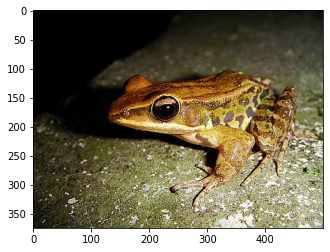

In [74]:
# 預測結果
result = loaded_model.predict(test_scaled)
import cv2
img=cv2.imread('./pic/'+labels[result[0]]+'.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(dict_frog[labels[result[0]]])
print(dict_frog_desc[labels[result[0]]])
plt.imshow(img)

# Other Test

In [47]:
import DataGenerator 
import FeatureExtraction

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\user\Anaconda3\lib\site-packages\librosa\core\audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

布氏樹蛙
樹蛙科，是分佈在中國大陸南方，西至西藏，北至甘肅、香港、海南島、台灣、印度的一種樹蛙，俗名白頷樹蛙，與另一種斑腿泛樹蛙相似。


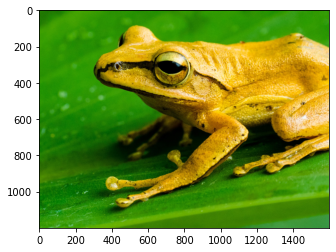

In [49]:
test = DataGenerator.generate()
test_data = FeatureExtraction.FeatureExtraction(test)

# 預測結果
loaded_model = joblib.load('SVM_model')
result = loaded_model.predict(test_scaled)

img=cv2.imread('./pic/'+labels[result[0]]+'.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(dict_frog[labels[result[0]]])
print(dict_frog_desc[labels[result[0]]])
plt.imshow(img)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\user\Anaconda3\lib\site-packages\librosa\core\audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]

王氏樹蛙
王氏樹蛙是2016年從艾氏樹蛙分出來的新種，體長3至5公分，樹棲性 夜行性。生態習性和艾氏樹蛙一樣，雄蛙會躲到有水的竹筒或樹洞內鳴叫，雄蛙有單一外鳴囊，叫聲是類似面天樹蛙較不規律的「逼、逼、逼」。 型態特徵：王氏樹蛙的體色多變，可從淡褐色變到綠色，皮膚上有許多顆粒狀的突起，背部有一個X或H型的深色斑，四肢外側有白色顆粒突出，小腿和足部相接處的白點最明顯。上眼瞼之間有一橫斑，腹部淺橘色。 三月到九月是主要的繁殖期。


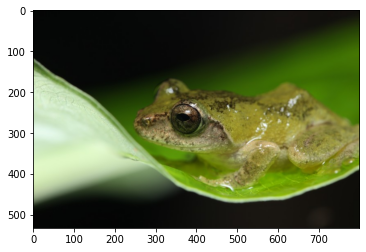

In [64]:
test = DataGenerator.generate()
test_data = FeatureExtraction.FeatureExtraction(test)

# 預測結果
loaded_model = joblib.load('SVM_model')
result = loaded_model.predict(test_scaled)

img=cv2.imread('./pic/'+labels[result[0]]+'.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(dict_frog[labels[result[0]]])
print(dict_frog_desc[labels[result[0]]])
plt.imshow(img)